<a href="https://colab.research.google.com/github/yaobviously/perkins_temp/blob/main/perkins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --upgrade plotly --quiet

     |████████████████████████████████| 20.6MB 36.8MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [4]:
pop_csv = '/content/drive/MyDrive/Temperature_Perkins/Population Data.csv'
temp_csv = '/content/drive/MyDrive/Temperature_Perkins/Temperature Data.csv'

A function was written inside of load_transform_data() to find each date with missing observations for each weather station. Those dates were then appended to the dataset and daily measurements were imputed using each weather station's rolling three day averages. 

The function that graphs daily monthly temperature data indicates where values were imputed.

In [5]:
def load_transform_data():
  """
  Preparing the temperature and population datasets for visualization and 
  analysis
  """

  temp_df = pd.read_csv(temp_csv, parse_dates=['location_date'])

  pop_df = pd.read_csv(pop_csv)

  # case normalizing pop columns
  pop_df.columns = pop_df.columns.str.lower()

  # dropping the wrong states
  mask = (pop_df['city'] == 'Richmond') & (pop_df['state'] == 'California')
  pop_df = pop_df[~mask].copy()

  mask2 = (pop_df['city'] == 'Columbus') & (pop_df['state'] == 'Georgia')
  pop_df = pop_df[~mask2].copy()

  # dropping redundant columns
  col_drop = ['country_name', 'country_code', 'continent']
  temp_df = temp_df.drop(col_drop, axis=1)

  # renaming columns - celsius will be indicated in viz
  temp_df = temp_df.rename(columns={'temp_mean_c': 'mean_temp',
                                    'temp_min_c' : 'min_temp',
                                    'temp_max_c' : 'max_temp'})

  # making it easier to merge with pop df
  temp_df['name'] = [x.split('/')[0] for x in temp_df['name']]
  temp_df = temp_df.rename(columns={'name':'city'})

  # creating a city dictionary to find matching city pops

  city_dict = {'St Louis' : 'St. Louis', 'NYC' : 'New York', "Chicago O'Hare" : 'Chicago',
               'Covington': 'Cincinnati', 'Wash DC' : 'Washington', 'Windsor Locks' : 'Hartford',
               'Albany' : 'Syracuse'
               }
  temp_df['city'] = temp_df['city'].map(city_dict).fillna(temp_df['city'])

  reverse_dict = {v:k for k,v in city_dict.items()}
  
  # merging the dataframes and mapping names to their originals
  merged_df = pd.merge(temp_df, pop_df, how='left', on='city')
  merged_df = merged_df.set_index('location_date').sort_index()

  # fixing  values in the dataframe manually - i hope this is permitted.  
  
  merged_df['city'] = merged_df['city'].map(reverse_dict).fillna(merged_df['city'])
  merged_df['city'] = merged_df['city'].replace('Wash DC', 'Washington (Dulles)')
  merged_df['city'] = np.where((merged_df['station_code'] == 'KDCA'), 'Washington (Reagan)', merged_df['city'])
  merged_df['city'] = np.where((merged_df['station_code'] == 'KPWM'), 'Portland (Maine)', merged_df['city'])
  merged_df['population'] = np.where((merged_df['city'] == 'Portland (Maine)'), 75000, merged_df['population'])
  merged_df['population'] = np.where((merged_df['city'] == 'Albany'), 97483, merged_df['population'])
  merged_df['state'] = np.where((merged_df['city'] == 'Portland (Maine)'), 'Maine', merged_df['state'])
  merged_df['lon'] = np.where((merged_df['city'] == 'Albany'), -73.7562, merged_df['lon'])
  merged_df['lat'] = np.where((merged_df['city'] == 'Albany'), 42.6526, merged_df['lat'])
  merged_df['lon'] = np.where((merged_df['city'] == 'Portland (Maine)'), -70.2568, merged_df['lon'])
  merged_df['lat'] = np.where((merged_df['city'] == 'Portland (Maine)'), 43.6591, merged_df['lat']) 
  
  # creating a function to find the dates with missing values for each
  # station and then appending all of those dates to the main dataframe

  days = merged_df.index.unique()

  def find_miss_days(station_code = 'KLIT'):    

    df_ = merged_df[merged_df['station_code'] == station_code]

    indexes = set(df_.index)
    dates_missing = set(days).difference(indexes)

    val_dict = {'city' : df_['city'][0],
                'station_code' : station_code,
                'state' : df_['state'][0],
                'population' : df_['population'][0],
                'lon' : df_['lon'][0],
                'lat' : df_['lat'][0]
                }

    new_df = pd.DataFrame(val_dict, index=tuple(dates_missing))

    return new_df

  # running the above function to create dfs to add to main df
  df_append = [find_miss_days(code) for code in merged_df.station_code.unique()]
  df_concat = pd.concat(df_append)

  df = merged_df.append(df_concat)

  # sorting the index to get the new rows where they belong
  df = df.sort_index()

  # creatin a multilevel index to ensure unique index values for all rows
  df = df.set_index('station_code', append=True)
  
  # extracting month/year from index to compute averages for each 
  # location
  df['month'] = pd.DatetimeIndex(df.index.get_level_values(0)).month
  df['year'] = pd.DatetimeIndex(df.index.get_level_values(0)).year

  # flagging rows that will have imputed daily temperature values
  df['imputed_mean'] = [1 if pd.isna(mean) else 0 for mean in df['mean_temp']] 

  # computing rolling averages for the purpose of imputation. utilizing 
  # shift, which is important!
  
  df['3day_rolling_mean'] = df.groupby(df.index.get_level_values(1))['mean_temp'].transform(lambda x: x.shift().rolling(3, min_periods=2).mean().fillna(method='ffill').fillna(method='bfill'))
  df['3day_rolling_max'] = df.groupby(df.index.get_level_values(1))['max_temp'].transform(lambda x: x.shift().rolling(3, min_periods=2).mean().fillna(method='ffill').fillna(method='bfill'))
  df['3day_rolling_min'] = df.groupby(df.index.get_level_values(1))['min_temp'].transform(lambda x: x.shift().rolling(3, min_periods=2).mean().fillna(method='ffill').fillna(method='bfill'))
  
  # computing 30 and 90 day rolling means - doesn't appear to be necessary but i'll leave it
  df['30day_rolling_mean'] = df.groupby(df.index.get_level_values(1))['mean_temp'].transform(lambda x: x.shift().rolling(30, min_periods=5).mean().fillna(method='ffill').fillna(method='bfill'))
  df['90day_rolling_mean'] = df.groupby(df.index.get_level_values(1))['mean_temp'].transform(lambda x: x.shift().rolling(90, min_periods=5).mean().fillna(method='ffill').fillna(method='bfill'))
  
  # filling in missing values with rolling average
  df['mean_temp'] = [y if pd.isna(x) else x for x, y in zip(df['mean_temp'], df['3day_rolling_mean'])]
  df['max_temp'] = [y if pd.isna(x) else x for x, y in zip(df['max_temp'], df['3day_rolling_max'])]
  df['min_temp'] = [y if pd.isna(x) else x for x, y in zip(df['min_temp'], df['3day_rolling_min'])]  
  
  # computing monthly average, max, and min for each station for this dataset. retrospectively computed. could do 'computed to date' using expanding()
  df['monthly_average_average'] = df.groupby([df.index.get_level_values(1), 'month'])['mean_temp'].transform(lambda x: x.mean())
  df['monthly_max_average'] = df.groupby([df.index.get_level_values(1), 'month'])['max_temp'].transform(lambda x: x.mean())
  df['monthly_min_average'] = df.groupby([df.index.get_level_values(1), 'month'])['min_temp'].transform(lambda x: x.mean())

  # computing the *specific* monthly average, high, and low as it rolls in
  df['this_month_avg_todate'] = df.groupby([df.index.get_level_values(1), 'year', 'month'])['mean_temp'].transform(lambda x: x.expanding().mean().fillna(method='bfill'))
  df['this_month_high_todate'] = df.groupby([df.index.get_level_values(1), 'year', 'month'])['max_temp'].transform(lambda x: x.expanding().max().fillna(method='bfill'))
  df['this_month_low_todate'] = df.groupby([df.index.get_level_values(1), 'year', 'month'])['mean_temp'].transform(lambda x: x.expanding().min().fillna(method='bfill'))

  # computing specific monthly avg, high, and low - not as it rolls in, but as it would be computed retrospectively
  df['this_month_average'] = df.groupby([df.index.get_level_values(1), 'year', 'month'])['mean_temp'].transform(lambda x: x.mean())
  df['this_month_high'] = df.groupby([df.index.get_level_values(1), 'year', 'month'])['max_temp'].transform(lambda x: x.max())
  df['this_month_low'] = df.groupby([df.index.get_level_values(1), 'year', 'month'])['mean_temp'].transform(lambda x: x.min())
  
  # rounding and altering columns for future user-friendliness (words for months)
  df['city_full'] = [", ".join(x) for x in zip(df['city'], df['state'])]
  drop_cols = ['city', 'state']

  month_dict = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June',
               7:'July', 8:'August', 9:'September', 10:'October', 11:'November',
               12:'December'}
  
  df['month'] = df['month'].map(month_dict)  
  df = df.drop(drop_cols, axis=1)
  df = df.round(2)  
  
  return df


In [ ]:
df = load_transform_data()

print("The shape of the new dataframe is:", df.shape)

The shape of the new dataframe is: (89778, 24)


In [ ]:
def monthly_average(city='Richmond, Virginia', month='April', year=2015):
  """
  A function that displays the daily mean, max, and min for a specific month
  and compares those values with the seasonal averages (within dataset)
  for each

  Imputed values are labelled

  Parameters
  ---------
    city: str
    month: str
    year: int

  Returns
  --------
    plot: matplot plot 
  """


  cols = ['mean_temp', 'max_temp', 'min_temp']
  df_ = df[(df['city_full'] == city) & (df['month'] == month) & (df['year'] == year)]
  df_ = df_.reset_index(level=1)

  imputed = df_[df_['imputed_mean'] == 1].index
  values = [df_.loc[i]['mean_temp'] for i in imputed]
  
  fig, ax = plt.subplots(figsize=(12,5))
  df_[cols].resample("D").mean().plot(ax=ax)
  
  plt.axhline(y=df_['monthly_average_average'].mean(), color='blue', ls='--', label='seasonal_mean')
  plt.axhline(y=df_['monthly_max_average'].mean(), color='orange', ls='--', label='seasonal_max')
  plt.axhline(y=df_['monthly_min_average'].mean(), color='green', ls='--', label='seasonal_min')
  plt.title(f"Daily Temperature Data for {city} in {month} of {year}")
  plt.xlabel("Day of Month")
  plt.ylabel("Temperature (C)")  

  for i in imputed:
    plt.axvline(i, ls='-', lw=2, color='red', label='imputed')
  
  plt.legend(shadow=True, loc='upper left', bbox_to_anchor=(1,1))
  plt.show()

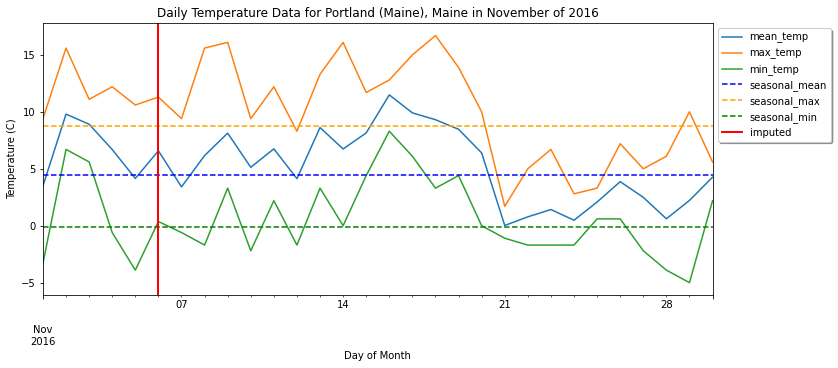

In [ ]:
monthly_average(city="Portland (Maine), Maine", month="November", year=2016)

In [ ]:
def get_monthly_data(city='Richmond, Virginia'):
  """
  A function that returns the maximum and minimum monthly values for a city in the
  dataset
  """

  df_ = df[df['city_full'] == city]
  df_ = df_.reset_index(level=1)

  fig, ax= plt.subplots(figsize=(12,5))
  df_['max_temp'].resample("M").max().plot(grid=True, ax=ax)
  df_['min_temp'].resample("M").min().plot(grid=True, ax=ax)
  

  plt.title(f"Monthly Max and Min Temperatures for {city}")
  plt.ylabel("Temperature(C)")
  plt.xlabel("Year")
  plt.legend()
  plt.show()

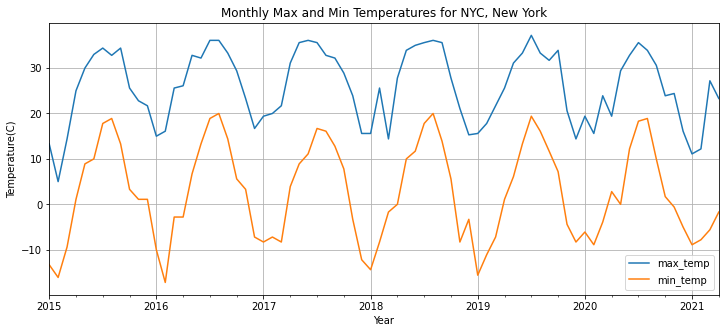

In [ ]:
get_monthly_data("NYC, New York")

In [ ]:
# a list of the valid cities to enter into the above functions. if this were a 
# Dash or Streamlit app these entries would be in a dropdown menu. I will
# do this now! 

valid_cities = df['city_full'].unique()

print(valid_cities)

['Phoenix, Arizona' 'Portland (Maine), Maine' 'Sacramento, California'
 'Seattle, Washington' 'Richmond, Virginia' 'St Louis, Missouri'
 'San Francisco, California' 'Washington (Dulles), District of Columbia'
 'Raleigh, North Carolina' 'Philadelphia, Pennsylvania'
 'New Orleans, Louisiana' 'Minneapolis, Minnesota' 'Memphis, Tennessee'
 'Little Rock, Arkansas' 'NYC, New York' 'Las Vegas, Nevada'
 'Portland, Oregon' "Chicago O'Hare, Illinois" 'Houston, Texas'
 'Salt Lake City, Utah' 'Spokane, Washington' 'Pittsburgh, Pennsylvania'
 'Denver, Colorado' 'Dallas, Texas' 'Covington, Ohio'
 'Washington (Reagan), District of Columbia' 'Columbus, Ohio'
 'Los Angeles, California' 'Detroit, Michigan' 'Baltimore, Maryland'
 'Fresno, California' 'Boston, Massachusetts' 'Boise, Idaho'
 'Nashville, Tennessee' 'Windsor Locks, Connecticut' 'Atlanta, Georgia'
 'Albany, New York' 'Burbank, California' 'Buffalo, New York']


In [ ]:
# # a mapbox plot of the cities included in the dataset

# fig = px.scatter_mapbox(df, lat="lat", lon="lon", hover_name = "city_full", zoom=3, height=500, mapbox_style="open-street-map")
# fig.update_layout(
#     mapbox_style="white-bg",
#     mapbox_layers=[
#         {
#             "below": 'traces',
#             "sourcetype": "raster",
#             "sourceattribution": "United States Geological Survey",
#             "source": [
#                 "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
#             ]
#         }
#       ])


# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

# fig.show()